In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [2]:
# 예측할 종목은 한양증권(001750) 입니다
# 기간은 00-01-04 ~ 21-02-05 입니다
# Yahoo Finanace에서 다운로드 받습니다 
# null값과 0값을 제거한 데이터를 사용합니다


df = pd.read_csv('C:\Jupyter_Project\HS_50_50_150.csv')
df = df.dropna()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-02-04,9140,9150,9020,9110,9110,30886
1,2020-02-05,9200,9200,9000,9040,9040,38531
2,2020-02-06,9140,9140,8760,8920,8920,92807
3,2020-02-07,8940,8940,8750,8860,8860,49339
4,2020-02-10,8860,8920,8650,8730,8730,29151


In [3]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
245,2021-02-01,9200,9480,9100,9380,9380,81355
246,2021-02-02,9460,9810,9460,9700,9700,105755
247,2021-02-03,9850,10200,9800,9990,9990,170966
248,2021-02-04,10100,10200,9940,10150,10150,133504
249,2021-02-05,10200,10800,10150,10650,10650,251300


In [4]:
# OHLC를 Adj OHLC로 바꾸기 위한 비율입니다
# Adj OHLC는 과거의 절대가격을 현재 가격의 시점으로 보기위한 수정된 가격입니다
# 과거 발생한 액면분할과 현금배당을 반영한 Adj Close를 기준으로 조정합니다

ratio = df['Adj Close']/df['Close']
ratio

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
245    1.0
246    1.0
247    1.0
248    1.0
249    1.0
Length: 250, dtype: float64

In [5]:
df['Adj Open'] = df['Open']*ratio
df['Adj High'] = df['High']*ratio
df['Adj Low'] = df['Low']*ratio

In [6]:
df.drop(['Open','High','Low','Close'], axis=1, inplace=True)

In [7]:
df.rename(columns={'Adj Open':'Open', 'Adj High':'High', 'Adj Low':'Low', 'Adj Close':'Close'}, inplace=True)

In [8]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

df

,Open,High,Low,Close,Volume
0,9140.0,9150.0,9020.0,9110,30886
1,9200.0,9200.0,9000.0,9040,38531
2,9140.0,9140.0,8760.0,8920,92807
3,8940.0,8940.0,8750.0,8860,49339
4,8860.0,8920.0,8650.0,8730,29151
...,...,...,...,...,...
245,9200.0,9480.0,9100.0,9380,81355
246,9460.0,9810.0,9460.0,9700,105755
247,9850.0,10200.0,9800.0,9990,170966
248,10100.0,10200.0,9940.0,10150,133504


In [9]:
scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

         Open      High       Low   Close    Volume
0    0.775947  0.732143  0.804159  0.7536  0.008378
1    0.785832  0.740260  0.800693  0.7424  0.011118
2    0.775947  0.730519  0.759099  0.7232  0.030576
3    0.742998  0.698052  0.757366  0.7136  0.014993
4    0.729819  0.694805  0.740035  0.6928  0.007756
..        ...       ...       ...     ...       ...
245  0.785832  0.785714  0.818024  0.7968  0.026470
246  0.828666  0.839286  0.880416  0.8480  0.035218
247  0.892916  0.902597  0.939341  0.8944  0.058595
248  0.934102  0.902597  0.963605  0.9200  0.045165
249  0.950577  1.000000  1.000000  1.0000  0.087394

[250 rows x 5 columns]


In [10]:
# 20일 학습하고 그 다음날 종가예측
# 테스트 기간은 21일, 따라서 5299-21 : train / 21 : test

window_size = 20
TEST_SIZE = 50

In [11]:
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [12]:
test.describe()

,Open,High,Low,Close,Volume
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.860099,0.836234,0.890711,0.840928,0.029913
std,0.048146,0.054000,0.046308,0.049635,0.025879
min,0.774300,0.735390,0.805893,0.752000,0.004691
25%,0.831137,0.800325,0.861785,0.813600,0.013071
50%,0.857496,0.831981,0.887348,0.834400,0.019257
75%,0.892916,0.865260,0.923744,0.870400,0.040130
max,1.000000,1.000000,1.000000,1.000000,0.137986


In [13]:
# 정해진 window_size에 기반하여 20일 기간의 데이터 셋을 묶어준다

def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [14]:
from sklearn.model_selection import train_test_split

feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train set : 모델을 학습하는 유일한 dataset
# validation set : 학습이 이미 완료된 모델을 검증하기 위한 dataset(비율 0.2) 

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.25)

x_train.shape, x_valid.shape
# ((4206, 20, 4), (1052, 20, 4))

# test dataset : 학습과 검증이 완료된 모델의 성능을 평가하기 위한 dataset
x_test = test[feature_cols]
y_test = test[label_cols]

x_test.shape, y_test.shape
#     (21, 4),          (21, 1)  

((50, 4), (50, 1))

In [15]:
x_test, y_test = make_dataset(x_test, y_test, 20)

x_test.shape, y_test.shape
# (21-20, 20, 4),     (21-20, 1)

((30, 20, 4), (30, 1))

In [16]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape, x_test.shape, y_test.shape

((135, 20, 4), (45, 20, 4), (135, 1), (45, 1), (30, 20, 4), (30, 1))

In [17]:
# print proportions
print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(df_scaled),2),
                                                       round(len(y_valid)/len(df_scaled),2),
                                                       round(len(y_test)/len(df_scaled),2)))

train: 0.54% | validation: 0.18% | test 0.12%


In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(20, 
               input_shape=(x_test.shape[1], x_test.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                2000      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 2,021
Trainable params: 2,021
Non-trainable params: 0
_________________________________________________________________


In [20]:
# val_loss가 10회 같을 시 early_stop, batch_size(=K)는 K문제 풀고 답보고 하는 식
# 위에서 모델을 구성한 후 compile 메서드를 호출하여 학습과정을 설정합니다
# optimizer : 훈련 과정을 설정한다
# loss : 최적화 과정에서 최소화될 손실 함수(loss function)을 설정합니다
# metrics : 훈련을 모니터링하기 위해 사용됩니다
# validation_data = 검증 데이터를 사용합니다. 각 에포크마다 정확도도 함께 출력됩니다
# 이 정확도는 훈련이 잘 되고 있는지를 보여줄 뿐이며 실제로 모델이 검증데이터를 학습하지는 않습니다
# 검증 데이터의 loss가 낮아지다가 높아지기 시작하면 overfitting의 신호입니다
# verbose / 0 : 출력 없음 / 1 : 훈련 진행도 보여주는 진행 막대 보여줌 / 2 : 미니 배치마다 손실 정보 출력

from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

def MPE(y_true, y_pred): 
    return K.mean((y_true - y_pred) / y_true) * 100
    
def MSLE(y_true, y_pred):
    return K.mean(K.square(K.log(y_true+1) - K.log(y_pred+1)), axis=-1)

def RMSLE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(y_true+1) - K.log(y_pred+1)), axis=-1))

def R2(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))
    
model.compile(loss = RMSE, optimizer='adam', metrics=[soft_acc, 'mse', 'mae', RMSE, 'mape', MPE, MSLE, RMSLE, R2])

early_stop = EarlyStopping(monitor='val_loss', patience=10)
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=1,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

# score_test를 만들면 테스트가 더이상 테스트가 아니고, 처음부터 모든 데이터에 대해 학습한 것과 같기 때문에 일반화 할 수 없는 모델을 만드는 것과 같다.


score_train = model.evaluate(x_train, y_train, batch_size=2)
score_validation = model.evaluate(x_valid, y_valid, batch_size=2)


Epoch 1/200
135/135 [==============================] - 5s 22ms/step - loss: 0.1608 - soft_acc: 0.8064 - mse: 0.0509 - mae: 0.1608 - RMSE: 0.1608 - mape: 34.6063 - MPE: 17.3592 - MSLE: 0.0250 - RMSLE: 0.1133 - R2: -509101.0296 - val_loss: 0.0465 - val_soft_acc: 0.9556 - val_mse: 0.0050 - val_mae: 0.0465 - val_RMSE: 0.0465 - val_mape: 4903599.0000 - val_MPE: -inf - val_MSLE: 0.0032 - val_RMSLE: 0.0339 - val_R2: -49678.4375

Epoch 00001: val_loss improved from inf to 0.04646, saving model to tmp\ckeckpointer.ckpt
INFO:tensorflow:Assets written to: tmp\ckeckpointer.ckpt\assets
Epoch 2/200
135/135 [==============================] - 1s 4ms/step - loss: 0.0415 - soft_acc: 0.9720 - mse: 0.0033 - mae: 0.0415 - RMSE: 0.0415 - mape: 12.5338 - MPE: -6.3770 - MSLE: 0.0016 - RMSLE: 0.0276 - R2: -33183.2030 - val_loss: 0.0538 - val_soft_acc: 0.9778 - val_mse: 0.0057 - val_mae: 0.0538 - val_RMSE: 0.0538 - val_mape: 4913216.0000 - val_MPE: -inf - val_MSLE: 0.0035 - val_RMSLE: 0.0385 - val_R2: -56597.63

135/135 [==============================] - 1s 4ms/step - loss: 0.0348 - soft_acc: 0.9243 - mse: 0.0021 - mae: 0.0348 - RMSE: 0.0348 - mape: 9.7556 - MPE: -1.9332 - MSLE: 9.3581e-04 - RMSLE: 0.0233 - R2: -20741.2218 - val_loss: 0.0338 - val_soft_acc: 0.9778 - val_mse: 0.0023 - val_mae: 0.0338 - val_RMSE: 0.0338 - val_mape: 3138385.5000 - val_MPE: -inf - val_MSLE: 0.0015 - val_RMSLE: 0.0243 - val_R2: -23452.9824

Epoch 00016: val_loss did not improve from 0.02587
Epoch 17/200
135/135 [==============================] - 1s 4ms/step - loss: 0.0342 - soft_acc: 0.9529 - mse: 0.0020 - mae: 0.0342 - RMSE: 0.0342 - mape: 7.5490 - MPE: -0.8355 - MSLE: 8.5148e-04 - RMSLE: 0.0221 - R2: -20221.9492 - val_loss: 0.0283 - val_soft_acc: 0.9778 - val_mse: 0.0017 - val_mae: 0.0283 - val_RMSE: 0.0283 - val_mape: 2645691.5000 - val_MPE: -inf - val_MSLE: 0.0011 - val_RMSLE: 0.0207 - val_R2: -16879.7695

Epoch 00017: val_loss did not improve from 0.02587
Epoch 18/200
135/135 [==============================] -

135/135 [==============================] - 1s 4ms/step - loss: 0.0251 - soft_acc: 0.9288 - mse: 0.0011 - mae: 0.0251 - RMSE: 0.0251 - mape: 6.3936 - MPE: -1.6963 - MSLE: 5.2285e-04 - RMSLE: 0.0167 - R2: -11184.5719 - val_loss: 0.0244 - val_soft_acc: 0.9778 - val_mse: 0.0014 - val_mae: 0.0244 - val_RMSE: 0.0244 - val_mape: 2538869.7500 - val_MPE: -inf - val_MSLE: 9.5845e-04 - val_RMSLE: 0.0179 - val_R2: -14178.9336

Epoch 00032: val_loss did not improve from 0.02361
Epoch 33/200
135/135 [==============================] - 1s 4ms/step - loss: 0.0277 - soft_acc: 0.9753 - mse: 0.0014 - mae: 0.0277 - RMSE: 0.0277 - mape: 6.6429 - MPE: -2.1596 - MSLE: 6.0476e-04 - RMSLE: 0.0181 - R2: -14028.5308 - val_loss: 0.0255 - val_soft_acc: 0.9778 - val_mse: 0.0015 - val_mae: 0.0255 - val_RMSE: 0.0255 - val_mape: 2554188.7500 - val_MPE: -inf - val_MSLE: 0.0010 - val_RMSLE: 0.0187 - val_R2: -15180.2236

Epoch 00033: val_loss did not improve from 0.02361
Epoch 34/200
135/135 [=============================

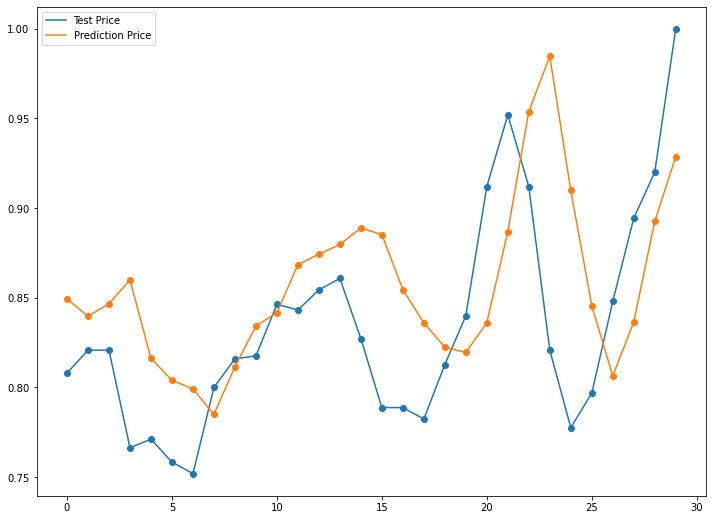

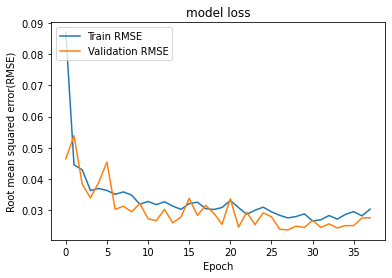

In [21]:
pred = model.predict(x_test)
pred.shape

plt.figure(figsize=(12,9))
plt.plot(np.asarray(y_test), label='Test Price')
plt.plot(pred, label='Prediction Price')
x_values = list(range(30))
plt.scatter(x_values, np.asarray(y_test))
plt.scatter(x_values, pred)
plt.legend()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Root mean squared error(RMSE)')
plt.xlabel('Epoch')
plt.legend(['Train RMSE', 'Validation RMSE'], loc='upper left')
plt.show()

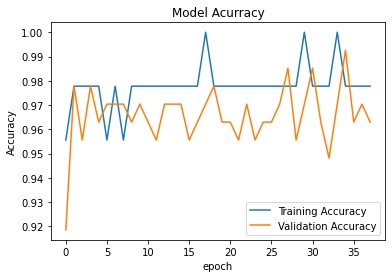

In [22]:
plt.plot(history.history['val_soft_acc'])
plt.plot(history.history['soft_acc'])
plt.title('Model Acurracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [23]:
accuracy_train = 100*score_train[1]
accuracy_validation = 100*score_validation[1]

print('train accuracy: %.4f%%' % accuracy_train)
print('validation accuracy: %.4f%%' % accuracy_validation)

train accuracy: 97.0588%
validation accuracy: 97.8261%


Text(0.5, 1.0, 'Prices vs Predicted price Index')

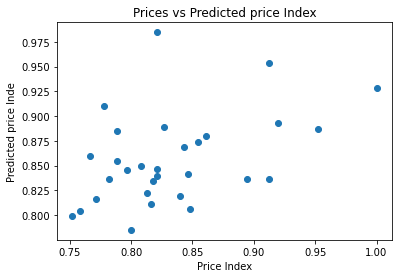

In [24]:
# 원래값과 예측 값이 일치하면 직선에 가깝게 분포가 된다

%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(np.asarray(y_test), pred)
plt.xlabel("Price Index")
plt.ylabel("Predicted price Inde")
plt.title("Prices vs Predicted price Index")

In [25]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import explained_variance_score

Y = np.asarray(y_test)
Y_hat = pred

def MSE(y_true, y_pred):
    return np.mean(np.square((y_true - y_pred)))

def MAE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred)))

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_pred-y_true)**2))

def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MPE(y_true, y_pred): 
    return np.mean((y_true - y_pred) / y_true) * 100

def root_mean_squared_log_error(y_true, y_pred): 
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

print('R2_Score')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}'.format(score_train[9], score_validation[9], r2_score(Y, Y_hat)))
print('Explained Variance Score(EVS) : {}|\n'.format(explained_variance_score(Y, Y_hat)))



print('Mean Squared Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[2], score_validation[2], MSE(Y, Y_hat)))

print('Mean Absolute Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[3], score_validation[3], MAE(Y, Y_hat)))

print('Root Mean Squared Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[4], score_validation[3], RMSE(Y, Y_hat)))

print('Mean Squared Logarithmic Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[7], score_validation[7], mean_squared_log_error(Y, Y_hat)))

print('Root Mean Squared Logarithmic Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[8], score_validation[8], root_mean_squared_log_error(Y, Y_hat)))

print('Mean Absolute Percentage Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[5], score_validation[3], MAPE(Y, Y_hat)))

print('Mean Percentage Error')
print('-' * 40)
print('train error: {} |\nvalid error: {} |\ntest error : {}\n'.format(score_train[6], score_validation[3], MPE(Y, Y_hat)))


R2_Score
----------------------------------------
train error: -516.8370361328125 |
valid error: -23.414474487304688 |
test error : -0.07840647401185508
Explained Variance Score(EVS) : 0.0765305996359682|

Mean Squared Error
----------------------------------------
train error: 0.001580777345225215 |
valid error: 0.0017504655988886952 |
test error : 0.0036666939741968963

Mean Absolute Error
----------------------------------------
train error: 0.02938239835202694 |
valid error: 0.02752009779214859 |
test error : 0.04853893313407894

Root Mean Squared Error
----------------------------------------
train error: 0.03367467597126961 |
valid error: 0.02752009779214859 |
test error : 0.06055323256603974

Mean Squared Logarithmic Error
----------------------------------------
train error: 0.0006768801249563694 |
valid error: 0.0011378105264157057 |
test error : 0.0010601417385373046

Root Mean Squared Logarithmic Error
----------------------------------------
train error: 0.01896030083298683

In [26]:
df=df_scaled
df

,Open,High,Low,Close,Volume
0,0.775947,0.732143,0.804159,0.7536,0.008378
1,0.785832,0.740260,0.800693,0.7424,0.011118
2,0.775947,0.730519,0.759099,0.7232,0.030576
3,0.742998,0.698052,0.757366,0.7136,0.014993
4,0.729819,0.694805,0.740035,0.6928,0.007756
...,...,...,...,...,...
245,0.785832,0.785714,0.818024,0.7968,0.026470
246,0.828666,0.839286,0.880416,0.8480,0.035218
247,0.892916,0.902597,0.939341,0.8944,0.058595
248,0.934102,0.902597,0.963605,0.9200,0.045165


In [27]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close',1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [28]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((200, 4), (50, 4), (200,), (50,))

In [29]:
from keras import models
from keras import layers
from keras import backend as K

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))


def build_model():
    # 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용합니다
    # 마지막 레이어는 주택가격인 Y값 1개만 예측하면 되기 때문에 뉴런 수는 1개
    model = models.Sequential()
    model.add(layers.Dense(20, activation='relu',
                           input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(1))
    
    
    model.compile(optimizer='adam', loss= RMSE, metrics=[soft_acc])
    return model

In [30]:
# k-겹 교차 검증 실시
# 현재 10겹이므로 한번 실행마다 100번 반복하고 결국 1000번을 훈련하게 된다
# #0의 10개의 mae평균, #1의 10개의 mae평균,,,100번째의 10개의 mae평균,,,이렇게 500개의 mae를 구한다


k = 10

num_val_samples = len(x_train) // k 
num_epochs = 100
all_scores = []

all_RMSE_histories_train = []

all_RMSE_histories_valid = []

all_Soft_acc_histories_train = []

all_Soft_acc_histories_valid = []

for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    x_valid = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    y_valid = y_train[i * num_val_samples: (i + 1) * num_val_samples]
 
    # 훈련 데이터 준비: 다른 분할 전체
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)
 
    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # model.fit()함수로 회귀 모델을 학습시킨다
    history = model.fit(partial_x_train, partial_y_train,
                        validation_data=(x_valid, y_valid),
                        epochs=num_epochs, batch_size=64, verbose=1)
    
    score_train = model.evaluate(partial_x_train, partial_y_train, batch_size=64)
    score_validation = model.evaluate(x_valid, y_valid, batch_size=64)

    RMSE_history_valid = history.history['val_loss']
    all_RMSE_histories_valid.append(RMSE_history_valid)
    
    RMSE_history_train = history.history['loss']
    all_RMSE_histories_train.append(RMSE_history_train)
    
    RMSE_history_train = history.history['soft_acc']
    all_Soft_acc_histories_train.append(RMSE_history_train)
    
    RMSE_history_valid = history.history['val_soft_acc']
    all_Soft_acc_histories_valid.append(RMSE_history_valid)
    
 
average_RMSE_valid = [np.mean([x[i] for x in all_RMSE_histories_valid]) for i in range(num_epochs)]

average_RMSE_train = [np.mean([x[i] for x in all_RMSE_histories_train]) for i in range(num_epochs)]

average_Soft_acc_train = [np.mean([x[i] for x in all_Soft_acc_histories_train]) for i in range(num_epochs)]

average_Soft_acc_valid = [np.mean([x[i] for x in all_Soft_acc_histories_valid]) for i in range(num_epochs)]

처리중인 폴드 # 0
Epoch 1/100
3/3 [==============================] - 1s 105ms/step - loss: 0.2855 - soft_acc: 0.5026 - val_loss: 0.2992 - val_soft_acc: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 22ms/step - loss: 0.2450 - soft_acc: 0.5138 - val_loss: 0.2575 - val_soft_acc: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 0s 27ms/step - loss: 0.2121 - soft_acc: 0.5480 - val_loss: 0.2157 - val_soft_acc: 0.1000
Epoch 4/100
3/3 [==============================] - 0s 26ms/step - loss: 0.1764 - soft_acc: 0.6229 - val_loss: 0.1739 - val_soft_acc: 0.4000
Epoch 5/100
3/3 [==============================] - 0s 27ms/step - loss: 0.1431 - soft_acc: 0.7776 - val_loss: 0.1330 - val_soft_acc: 0.7500
Epoch 6/100
3/3 [==============================] - 0s 27ms/step - loss: 0.1035 - soft_acc: 0.9053 - val_loss: 0.0948 - val_soft_acc: 0.9000
Epoch 7/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0784 - soft_acc: 0.9799 - val_loss: 0.0592 - val_soft_acc: 1.0000

3/3 [==============================] - 0s 24ms/step - loss: 0.0180 - soft_acc: 0.9831 - val_loss: 0.0126 - val_soft_acc: 1.0000
Epoch 59/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0181 - soft_acc: 0.9870 - val_loss: 0.0129 - val_soft_acc: 1.0000
Epoch 60/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0176 - soft_acc: 0.9870 - val_loss: 0.0129 - val_soft_acc: 1.0000
Epoch 61/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0180 - soft_acc: 0.9870 - val_loss: 0.0127 - val_soft_acc: 1.0000
Epoch 62/100
3/3 [==============================] - ETA: 0s - loss: 0.0167 - soft_acc: 0.98 - 0s 21ms/step - loss: 0.0177 - soft_acc: 0.9883 - val_loss: 0.0129 - val_soft_acc: 1.0000
Epoch 63/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0182 - soft_acc: 0.9870 - val_loss: 0.0128 - val_soft_acc: 1.0000
Epoch 64/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0182 - soft_acc: 0.9831 - val_loss: 0.0124 - val_s

3/3 [==============================] - 0s 24ms/step - loss: 0.1921 - soft_acc: 0.4929 - val_loss: 0.0713 - val_soft_acc: 1.0000
Epoch 15/100
3/3 [==============================] - 0s 22ms/step - loss: 0.1728 - soft_acc: 0.5561 - val_loss: 0.0737 - val_soft_acc: 1.0000
Epoch 16/100
3/3 [==============================] - 0s 22ms/step - loss: 0.1494 - soft_acc: 0.7667 - val_loss: 0.0787 - val_soft_acc: 1.0000
Epoch 17/100
3/3 [==============================] - 0s 22ms/step - loss: 0.1240 - soft_acc: 0.8792 - val_loss: 0.0858 - val_soft_acc: 1.0000
Epoch 18/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1012 - soft_acc: 0.9461 - val_loss: 0.0945 - val_soft_acc: 1.0000
Epoch 19/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0822 - soft_acc: 0.9792 - val_loss: 0.1038 - val_soft_acc: 1.0000
Epoch 20/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0672 - soft_acc: 0.9740 - val_loss: 0.1132 - val_soft_acc: 0.9500
Epoch 21/100
3/3 [========

Epoch 72/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0166 - soft_acc: 0.9831 - val_loss: 0.0307 - val_soft_acc: 1.0000
Epoch 73/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0170 - soft_acc: 0.9831 - val_loss: 0.0308 - val_soft_acc: 1.0000
Epoch 74/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0169 - soft_acc: 0.9909 - val_loss: 0.0307 - val_soft_acc: 1.0000
Epoch 75/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0149 - soft_acc: 0.9883 - val_loss: 0.0305 - val_soft_acc: 1.0000
Epoch 76/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0161 - soft_acc: 0.9936 - val_loss: 0.0307 - val_soft_acc: 1.0000
Epoch 77/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0166 - soft_acc: 0.9883 - val_loss: 0.0309 - val_soft_acc: 1.0000
Epoch 78/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0160 - soft_acc: 0.9922 - val_loss: 0.0307 - val_soft_acc: 1.0000
Epoch 79/100


Epoch 29/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0450 - soft_acc: 0.9376 - val_loss: 0.0716 - val_soft_acc: 1.0000
Epoch 30/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0372 - soft_acc: 0.9429 - val_loss: 0.0678 - val_soft_acc: 1.0000
Epoch 31/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0406 - soft_acc: 0.9488 - val_loss: 0.0625 - val_soft_acc: 1.0000
Epoch 32/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0367 - soft_acc: 0.9767 - val_loss: 0.0570 - val_soft_acc: 1.0000
Epoch 33/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0366 - soft_acc: 0.9708 - val_loss: 0.0528 - val_soft_acc: 1.0000
Epoch 34/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0348 - soft_acc: 0.9655 - val_loss: 0.0502 - val_soft_acc: 1.0000
Epoch 35/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0317 - soft_acc: 0.9668 - val_loss: 0.0489 - val_soft_acc: 1.0000
Epoch 36/100


3/3 [==============================] - 0s 22ms/step - loss: 0.0117 - soft_acc: 0.9838 - val_loss: 0.0127 - val_soft_acc: 1.0000
Epoch 88/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0117 - soft_acc: 0.9877 - val_loss: 0.0127 - val_soft_acc: 1.0000
Epoch 89/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0120 - soft_acc: 0.9890 - val_loss: 0.0126 - val_soft_acc: 1.0000
Epoch 90/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0117 - soft_acc: 0.9799 - val_loss: 0.0127 - val_soft_acc: 1.0000
Epoch 91/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0123 - soft_acc: 0.9838 - val_loss: 0.0127 - val_soft_acc: 1.0000
Epoch 92/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0117 - soft_acc: 0.9785 - val_loss: 0.0127 - val_soft_acc: 1.0000
Epoch 93/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0123 - soft_acc: 0.9785 - val_loss: 0.0127 - val_soft_acc: 1.0000
Epoch 94/100
3/3 [========

Epoch 44/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0197 - soft_acc: 0.9909 - val_loss: 0.0466 - val_soft_acc: 0.9500
Epoch 45/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0192 - soft_acc: 0.9870 - val_loss: 0.0457 - val_soft_acc: 0.9500
Epoch 46/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0197 - soft_acc: 0.9831 - val_loss: 0.0448 - val_soft_acc: 0.9500
Epoch 47/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0203 - soft_acc: 0.9799 - val_loss: 0.0441 - val_soft_acc: 0.9500
Epoch 48/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0175 - soft_acc: 0.9877 - val_loss: 0.0440 - val_soft_acc: 0.9500
Epoch 49/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0201 - soft_acc: 0.9922 - val_loss: 0.0435 - val_soft_acc: 0.9500
Epoch 50/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0174 - soft_acc: 0.9922 - val_loss: 0.0434 - val_soft_acc: 0.9500
Epoch 51/100


1/1 [==============================] - 0s 15ms/step - loss: 0.0388 - soft_acc: 0.9500
처리중인 폴드 # 4
Epoch 1/100
3/3 [==============================] - 1s 98ms/step - loss: 0.0543 - soft_acc: 0.9675 - val_loss: 0.0275 - val_soft_acc: 1.0000
Epoch 2/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0297 - soft_acc: 0.9792 - val_loss: 0.0248 - val_soft_acc: 0.8500
Epoch 3/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0271 - soft_acc: 0.9870 - val_loss: 0.0294 - val_soft_acc: 0.8000
Epoch 4/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0326 - soft_acc: 0.9922 - val_loss: 0.0268 - val_soft_acc: 0.8500
Epoch 5/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0340 - soft_acc: 0.9883 - val_loss: 0.0233 - val_soft_acc: 0.9000
Epoch 6/100
3/3 [==============================] - ETA: 0s - loss: 0.0226 - soft_acc: 1.00 - 0s 20ms/step - loss: 0.0241 - soft_acc: 0.9890 - val_loss: 0.0235 - val_soft_acc: 0.9000
Epoch 7/100
3/3 [===

3/3 [==============================] - 0s 22ms/step - loss: 0.0204 - soft_acc: 0.9909 - val_loss: 0.0221 - val_soft_acc: 0.9000
Epoch 59/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0193 - soft_acc: 0.9954 - val_loss: 0.0227 - val_soft_acc: 0.9000
Epoch 60/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0203 - soft_acc: 0.9954 - val_loss: 0.0225 - val_soft_acc: 0.9000
Epoch 61/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0185 - soft_acc: 0.9915 - val_loss: 0.0221 - val_soft_acc: 0.9000
Epoch 62/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0197 - soft_acc: 0.9968 - val_loss: 0.0220 - val_soft_acc: 0.9000
Epoch 63/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0195 - soft_acc: 0.9915 - val_loss: 0.0223 - val_soft_acc: 0.9000
Epoch 64/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0193 - soft_acc: 0.9968 - val_loss: 0.0221 - val_soft_acc: 0.9000
Epoch 65/100
3/3 [========

Epoch 15/100
3/3 [==============================] - 0s 20ms/step - loss: 0.2933 - soft_acc: 0.4456 - val_loss: 0.2214 - val_soft_acc: 0.4000
Epoch 16/100
3/3 [==============================] - 0s 20ms/step - loss: 0.2690 - soft_acc: 0.4507 - val_loss: 0.1934 - val_soft_acc: 0.4000
Epoch 17/100
3/3 [==============================] - 0s 23ms/step - loss: 0.2413 - soft_acc: 0.4434 - val_loss: 0.1656 - val_soft_acc: 0.4000
Epoch 18/100
3/3 [==============================] - 0s 22ms/step - loss: 0.2160 - soft_acc: 0.4460 - val_loss: 0.1381 - val_soft_acc: 0.4000
Epoch 19/100
3/3 [==============================] - 0s 21ms/step - loss: 0.1870 - soft_acc: 0.5303 - val_loss: 0.1113 - val_soft_acc: 0.4000
Epoch 20/100
3/3 [==============================] - 0s 19ms/step - loss: 0.1613 - soft_acc: 0.7262 - val_loss: 0.0851 - val_soft_acc: 0.4000
Epoch 21/100
3/3 [==============================] - 0s 23ms/step - loss: 0.1357 - soft_acc: 0.9148 - val_loss: 0.0607 - val_soft_acc: 0.6500
Epoch 22/100


3/3 [==============================] - 0s 23ms/step - loss: 0.0145 - soft_acc: 0.9915 - val_loss: 0.0108 - val_soft_acc: 0.9500
Epoch 74/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0147 - soft_acc: 0.9954 - val_loss: 0.0108 - val_soft_acc: 0.9500
Epoch 75/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0138 - soft_acc: 0.9915 - val_loss: 0.0108 - val_soft_acc: 0.9500
Epoch 76/100
3/3 [==============================] - 0s 28ms/step - loss: 0.0144 - soft_acc: 0.9954 - val_loss: 0.0108 - val_soft_acc: 0.9500
Epoch 77/100
3/3 [==============================] - 0s 26ms/step - loss: 0.0143 - soft_acc: 0.9968 - val_loss: 0.0108 - val_soft_acc: 0.9500
Epoch 78/100
3/3 [==============================] - 0s 26ms/step - loss: 0.0148 - soft_acc: 0.9954 - val_loss: 0.0108 - val_soft_acc: 0.9500
Epoch 79/100
3/3 [==============================] - 0s 25ms/step - loss: 0.0146 - soft_acc: 0.9968 - val_loss: 0.0108 - val_soft_acc: 0.9500
Epoch 80/100
3/3 [========

3/3 [==============================] - 0s 20ms/step - loss: 0.1054 - soft_acc: 0.8995 - val_loss: 0.0741 - val_soft_acc: 1.0000
Epoch 30/100
3/3 [==============================] - 0s 22ms/step - loss: 0.1082 - soft_acc: 0.8260 - val_loss: 0.0636 - val_soft_acc: 1.0000
Epoch 31/100
3/3 [==============================] - 0s 22ms/step - loss: 0.1043 - soft_acc: 0.7820 - val_loss: 0.0586 - val_soft_acc: 1.0000
Epoch 32/100
3/3 [==============================] - 0s 20ms/step - loss: 0.1008 - soft_acc: 0.7811 - val_loss: 0.0582 - val_soft_acc: 1.0000
Epoch 33/100
3/3 [==============================] - 0s 24ms/step - loss: 0.1007 - soft_acc: 0.7768 - val_loss: 0.0611 - val_soft_acc: 1.0000
Epoch 34/100
3/3 [==============================] - 0s 22ms/step - loss: 0.1044 - soft_acc: 0.8405 - val_loss: 0.0665 - val_soft_acc: 1.0000
Epoch 35/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0994 - soft_acc: 0.8682 - val_loss: 0.0728 - val_soft_acc: 1.0000
Epoch 36/100
3/3 [========

3/3 [==============================] - 0s 23ms/step - loss: 0.0177 - soft_acc: 0.9831 - val_loss: 0.0235 - val_soft_acc: 1.0000
Epoch 88/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0167 - soft_acc: 0.9870 - val_loss: 0.0236 - val_soft_acc: 1.0000
Epoch 89/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0164 - soft_acc: 0.9922 - val_loss: 0.0233 - val_soft_acc: 1.0000
Epoch 90/100
3/3 [==============================] - 0s 22ms/step - loss: 0.0162 - soft_acc: 0.9922 - val_loss: 0.0231 - val_soft_acc: 1.0000
Epoch 91/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0152 - soft_acc: 0.9883 - val_loss: 0.0229 - val_soft_acc: 1.0000
Epoch 92/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0152 - soft_acc: 0.9909 - val_loss: 0.0229 - val_soft_acc: 1.0000
Epoch 93/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0147 - soft_acc: 0.9870 - val_loss: 0.0231 - val_soft_acc: 1.0000
Epoch 94/100
3/3 [========

Epoch 44/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0176 - soft_acc: 0.9870 - val_loss: 0.0130 - val_soft_acc: 1.0000
Epoch 45/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0182 - soft_acc: 0.9909 - val_loss: 0.0135 - val_soft_acc: 1.0000
Epoch 46/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0180 - soft_acc: 0.9909 - val_loss: 0.0132 - val_soft_acc: 1.0000
Epoch 47/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0175 - soft_acc: 0.9883 - val_loss: 0.0128 - val_soft_acc: 1.0000
Epoch 48/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0171 - soft_acc: 0.9883 - val_loss: 0.0129 - val_soft_acc: 1.0000
Epoch 49/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0175 - soft_acc: 0.9883 - val_loss: 0.0132 - val_soft_acc: 1.0000
Epoch 50/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0166 - soft_acc: 0.9870 - val_loss: 0.0136 - val_soft_acc: 1.0000
Epoch 51/100


1/1 [==============================] - 0s 13ms/step - loss: 0.0135 - soft_acc: 1.0000
처리중인 폴드 # 8
Epoch 1/100
3/3 [==============================] - 1s 93ms/step - loss: 0.6802 - soft_acc: 0.4868 - val_loss: 0.7918 - val_soft_acc: 0.0000e+00
Epoch 2/100
3/3 [==============================] - 0s 19ms/step - loss: 0.6588 - soft_acc: 0.4632 - val_loss: 0.7508 - val_soft_acc: 0.0000e+00
Epoch 3/100
3/3 [==============================] - 0s 18ms/step - loss: 0.6209 - soft_acc: 0.4620 - val_loss: 0.7107 - val_soft_acc: 0.0000e+00
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 0.5829 - soft_acc: 0.4647 - val_loss: 0.6729 - val_soft_acc: 0.0000e+00
Epoch 5/100
3/3 [==============================] - 0s 21ms/step - loss: 0.5355 - soft_acc: 0.5041 - val_loss: 0.6358 - val_soft_acc: 0.0000e+00
Epoch 6/100
3/3 [==============================] - 0s 20ms/step - loss: 0.5081 - soft_acc: 0.4948 - val_loss: 0.5986 - val_soft_acc: 0.0000e+00
Epoch 7/100
3/3 [=====================

Epoch 58/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0170 - soft_acc: 0.9922 - val_loss: 0.0161 - val_soft_acc: 1.0000
Epoch 59/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0170 - soft_acc: 0.9831 - val_loss: 0.0161 - val_soft_acc: 1.0000
Epoch 60/100
3/3 [==============================] - ETA: 0s - loss: 0.0168 - soft_acc: 0.96 - 0s 20ms/step - loss: 0.0169 - soft_acc: 0.9831 - val_loss: 0.0163 - val_soft_acc: 1.0000
Epoch 61/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0172 - soft_acc: 0.9909 - val_loss: 0.0163 - val_soft_acc: 1.0000
Epoch 62/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0167 - soft_acc: 0.9936 - val_loss: 0.0163 - val_soft_acc: 1.0000
Epoch 63/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0178 - soft_acc: 0.9870 - val_loss: 0.0163 - val_soft_acc: 1.0000
Epoch 64/100
3/3 [==============================] - 0s 20ms/step - loss: 0.0172 - soft_acc: 0.9922 - val_loss: 0

Epoch 14/100
3/3 [==============================] - 0s 23ms/step - loss: 0.1943 - soft_acc: 0.4714 - val_loss: 0.2947 - val_soft_acc: 0.4500
Epoch 15/100
3/3 [==============================] - 0s 23ms/step - loss: 0.1668 - soft_acc: 0.4997 - val_loss: 0.2545 - val_soft_acc: 1.0000
Epoch 16/100
3/3 [==============================] - 0s 22ms/step - loss: 0.1424 - soft_acc: 0.6943 - val_loss: 0.2147 - val_soft_acc: 1.0000
Epoch 17/100
3/3 [==============================] - 0s 28ms/step - loss: 0.1129 - soft_acc: 0.8927 - val_loss: 0.1759 - val_soft_acc: 1.0000
Epoch 18/100
3/3 [==============================] - 0s 31ms/step - loss: 0.0903 - soft_acc: 0.9598 - val_loss: 0.1391 - val_soft_acc: 1.0000
Epoch 19/100
3/3 [==============================] - 0s 33ms/step - loss: 0.0753 - soft_acc: 0.9785 - val_loss: 0.1055 - val_soft_acc: 1.0000
Epoch 20/100
3/3 [==============================] - 0s 47ms/step - loss: 0.0713 - soft_acc: 0.9696 - val_loss: 0.0781 - val_soft_acc: 1.0000
Epoch 21/100


3/3 [==============================] - 0s 19ms/step - loss: 0.0150 - soft_acc: 0.9824 - val_loss: 0.0182 - val_soft_acc: 1.0000
Epoch 73/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0154 - soft_acc: 0.9838 - val_loss: 0.0185 - val_soft_acc: 1.0000
Epoch 74/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0161 - soft_acc: 0.9851 - val_loss: 0.0174 - val_soft_acc: 1.0000
Epoch 75/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0164 - soft_acc: 0.9838 - val_loss: 0.0166 - val_soft_acc: 1.0000
Epoch 76/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0148 - soft_acc: 0.9838 - val_loss: 0.0181 - val_soft_acc: 1.0000
Epoch 77/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0143 - soft_acc: 0.9746 - val_loss: 0.0180 - val_soft_acc: 1.0000
Epoch 78/100
3/3 [==============================] - 0s 32ms/step - loss: 0.0154 - soft_acc: 0.9799 - val_loss: 0.0173 - val_soft_acc: 1.0000
Epoch 79/100
3/3 [========

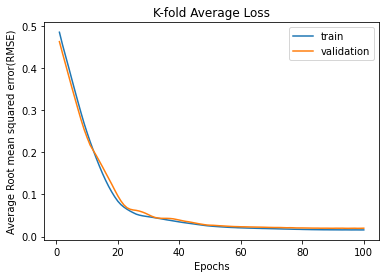

In [31]:
plt.plot(range(1, len(average_RMSE_train) + 1), average_RMSE_train)
plt.plot(range(1, len(average_RMSE_valid) + 1), average_RMSE_valid)
plt.title('K-fold Average Loss')
plt.xlabel('Epochs')
plt.ylabel('Average Root mean squared error(RMSE)')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

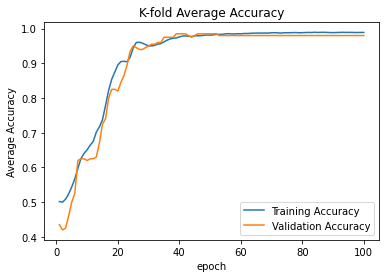

In [32]:
plt.plot(range(1, len(average_Soft_acc_train) + 1), average_Soft_acc_train)
plt.plot(range(1, len(average_Soft_acc_valid) + 1), average_Soft_acc_valid)
plt.title('K-fold Average Accuracy')
plt.ylabel('Average Accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()